In [63]:
import pickle

import cartopy.crs as ccrs
import cartopy.geodesic as cgeo
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [64]:
grid_angle_file = "/data/grids/ecc/riops/grid_angle_riops_ps5km60n.nc"
x_vel_file = "/home/ubuntu/ONavScripts/rotate_caps/riops/20250701T00Z_MSC_RIOPS_VOZOCRTX_DBS-all_PS5km_P000.nc"
y_vel_file = "/home/ubuntu/ONavScripts/rotate_caps/riops/20250701T00Z_MSC_RIOPS_VOMECRTY_DBS-all_PS5km_P000.nc"

proj = ccrs.NorthPolarStereo(central_longitude=-100)

In [65]:
x_vel = xr.open_dataset(x_vel_file)
y_vel = xr.open_dataset(y_vel_file)
grid_angle = xr.open_dataset(grid_angle_file)

In [66]:
x_vel.polar_stereographic

<xarray.DataArray 'polar_stereographic' ()>
[1 values with dtype=|S1]
Attributes:
    grid_mapping_name:                      polar_stereographic
    earth_radius:                           6371229.0
    latitude_of_projection_origin:          90.0
    straight_vertical_longitude_from_pole:  -100.0
    scale_factor_at_projection_origin:      0.9330124
    false_easting:                          4245000.0
    false_northing:                         5295000.0

In [67]:
lat_0 = np.deg2rad(x_vel.latitude.data[1:-1, :-1])
lat_1 = np.deg2rad(x_vel.latitude.data[1:-1:, 1:])

lon_0 = np.deg2rad(x_vel.longitude.data[1:-1, :-1])
lon_1 = np.deg2rad(x_vel.longitude.data[1:-1:, 1:])

In [68]:
zxnpt = 0.0 - 2.0 * np.cos(lon_1) * np.tan(
    np.pi / 4.0 - lat_1 / 2.0
)
zynpt = 0.0 - 2.0 * np.sin(lon_1) * np.tan(
    np.pi / 4.0 - lat_1 / 2.0
)
znnpt = zxnpt * zxnpt + zynpt * zynpt

In [69]:
zxuut = 2.0 * np.cos(lon_1) * np.tan(
    np.pi / 4.0 - lat_1 / 2.0
) - 2.0 * np.cos(lon_0) * np.tan(np.pi / 4.0 - lat_0 / 2.0)
zyuut = 2.0 * np.sin(lon_1) * np.tan(
    np.pi / 4.0 - lat_1 / 2.0
) - 2.0 * np.sin(lon_0) * np.tan(np.pi / 4.0 - lat_0 / 2.0)
znuut = np.sqrt(znnpt * (zxuut * zxuut + zyuut * zyuut))
# znuut[znuut < 1.0e-14] = 1.0e-14
# znuut = max(znuut, 1.0e-14)

In [70]:
idx = np.argwhere(znuut< 1.0e-14)
znuut[idx] = 1.0e-14

In [71]:
gsint = (zxnpt * zxuut + zynpt * zyuut) / znuut
gcost = -(zxnpt * zyuut - zynpt * zxuut) / znuut

In [72]:
for var in [gsint, gcost]:
    var[:, 0] = var[:, 1]
# Last row copied from second last row
for var in [gsint, gcost]:
    var[:, -1] = var[:, -2]
# First column copied from second column
for var in [gsint, gcost]:
    var[0, :] = var[1, :]
# Last column copied from second last column
for var in [gsint, gcost]:
    var[-1, :] = var[-2, :]

In [73]:
theta = np.rad2deg(np.arctan2(gsint, gcost))
theta

array([[  38.696304,   38.696304,   38.670567, ...,  -41.006184,
         -41.006256,  -41.006256],
       [  38.696304,   38.696304,   38.670567, ...,  -41.006184,
         -41.006256,  -41.006256],
       [  38.757355,   38.757355,   38.690445, ...,  -41.03325 ,
         -41.01264 ,  -41.01264 ],
       ...,
       [ 122.85321 ,  122.85321 ,  122.88549 , ..., -120.79366 ,
        -120.755554, -120.755554],
       [ 122.89883 ,  122.89883 ,  122.94124 , ..., -120.83571 ,
        -120.802025, -120.802025],
       [ 122.89883 ,  122.89883 ,  122.94124 , ..., -120.83571 ,
        -120.802025, -120.802025]], dtype=float32)

In [74]:
b = 90-np.degrees(np.arctan2( np.sin(lon_1-lon_0) * np.cos(lat_1), np.cos(lat_0) * np.sin(lat_1) - np.sin(lat_0) * np.cos(lat_1) *np.cos(lon_1-lon_0)))
b.shape

(1608, 1769)

In [75]:
lat_0 = x_vel.latitude.data[1:-1, :-1].flatten()
lat_1 = x_vel.latitude.data[1:-1:, 1:].flatten()

lon_0 = x_vel.longitude.data[1:-1, :-1].flatten()
lon_1 = x_vel.longitude.data[1:-1:, 1:].flatten()

start = np.array([lon_0, lat_0]).transpose()
end = np.array([lon_1, lat_1]).transpose()

In [76]:
geod = cgeo.Geodesic()#radius=6371229.0)
azimuth = geod.inverse(start, end)

In [77]:
90 - azimuth[:,1]

array([ 38.61023724,  38.56404226,  38.52143339, ..., 238.99568831,
       239.02950982, 239.06165726])

In [78]:
ll_grid_x = x_vel.longitude.data
ll_grid_y = x_vel.latitude.data

for n in range(ll_grid_x.shape[0] - 1):
    x = ll_grid_x[n]
    x[x > 180] = x[x > 180] - 360
    # sort_idx = np.argsort(x)
    ll_grid_x[n] = x
    # ll_grid_x[n] = x[sort_idx]
    # ll_grid_y[n] = ll_grid_y[n][sort_idx]

ll_grid_x_lines = np.array([[ll_grid_x[n,:], ll_grid_y[n,:]] for n in range(ll_grid_x.shape[0])])
ll_grid_y_lines = np.array([[ll_grid_x[:,n], ll_grid_y[:,n]] for n in range(ll_grid_x.shape[1])])    

In [79]:
ps_grid = proj.transform_points(ccrs.PlateCarree(), x_vel.longitude.data, x_vel.latitude.data)
ps_grid_x = ps_grid[:,:,0]
ps_grid_y = ps_grid[:,:,1]
ps_grid_y_lines = np.array([[ps_grid_x[n,:], ps_grid_y[n,:]] for n in range(ps_grid.shape[0])])
ps_grid_x_lines = np.array([[ps_grid_x[:,n], ps_grid_y[:,n]] for n in range(ps_grid.shape[1])])

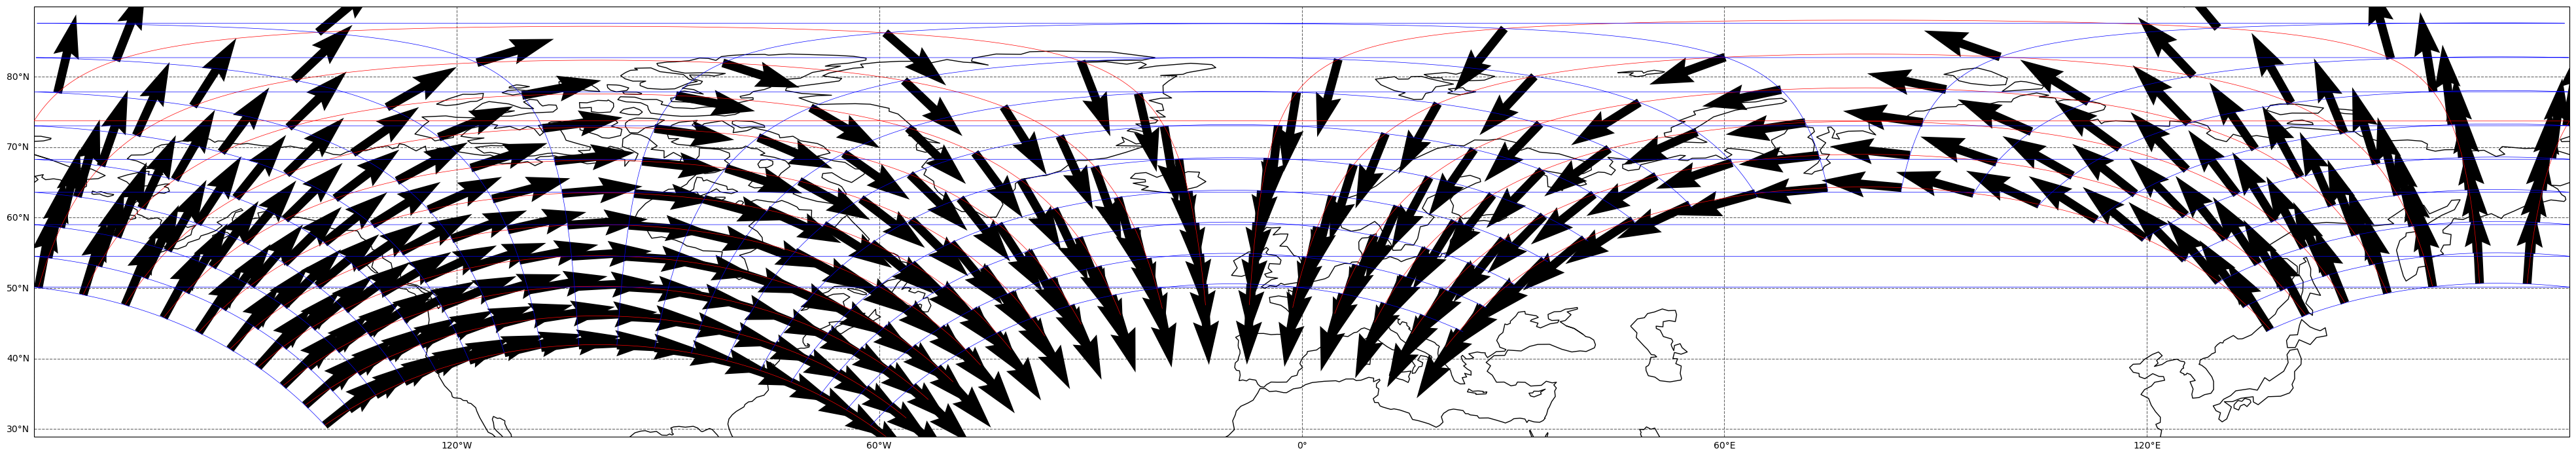

In [80]:
plt.figure(figsize=(50, 50))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
# ax.set_extent([-60, -50, 45, 55], crs=ccrs.PlateCarree())
# ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())
ax.set_extent(
    [
        x_vel.longitude.data.min(),
        x_vel.longitude.data.max(),
        x_vel.latitude.data.min(),
        x_vel.latitude.data.max(),
    ],
    crs=ccrs.PlateCarree(),
)
gridliner = ax.gridlines(
    draw_labels=True, crs=ccrs.PlateCarree(), color="k", alpha=0.6, linestyle="--"
)
gridliner.top_labels = False
gridliner.right_labels = False

# plt.plot(ll_grid_x_lines[0][0], ll_grid_x_lines[0][1], zorder=10, linewidth=0.5, color="red")

for line in ll_grid_x_lines[::100]:
    plt.plot(*line, zorder=10, linewidth=0.5, color="red")

for line in ll_grid_y_lines[::100]:
    plt.plot(*line, zorder=10, linewidth=0.5, color="blue")


ax.quiver(
    grid_angle.longitude.data[::100,::100],
    grid_angle.latitude.data[::100,::100],
    np.cos(np.deg2rad(grid_angle.alpha.data))[::100,::100],
    np.sin(np.deg2rad(grid_angle.alpha.data))[::100,::100],
    transform=ccrs.PlateCarree(),
)

plt.show()

In [81]:
line = ll_grid_x_lines[1]
line

array([[-138.74402 , -138.71107 , -138.67809 , ...,  -59.052124,
         -59.02124 ,  -58.990417],
       [  30.5887  ,   30.61145 ,   30.63419 , ...,   28.99233 ,
          28.96888 ,   28.94542 ]], dtype=float32)

In [82]:
a = [line[0,1], line[1,1]] 
b = [line[0,2], line[1,2]]
print(a,b)

[-138.71107, 30.61145] [-138.67809, 30.63419]


In [83]:
import pyproj
geodesic = pyproj.Geod(ellps='WGS84')
fwd_azimuth,back_azimuth,distance = geodesic.inv(a[0], a[1], b[0], b[1])

In [84]:
90-fwd_azimuth

38.5640422611737

In [85]:
geod = cgeo.Geodesic(radius=6371229.0)
azimuth = geod.inverse(a, b)
90-azimuth[0][2]

38.547237929641085

In [86]:
grid_angle.alpha.data[1,1]

38.724598

In [87]:
np.degrees(azimuth[0][2])

2948.0261109223698

In [88]:
a[0], a[1], b[0], b[1]

(-138.71107, 30.61145, -138.67809, 30.63419)

In [89]:
a = [line[0,1], line[1,1]] 
b = [line[0,2], line[1,2]]

In [90]:
l1 = (a[0].copy() + 360) * np.pi / 180
l2 = (b[0].copy() + 360) * np.pi / 180

p1 = a[1].copy() * np.pi / 180
p2 = b[1].copy() * np.pi / 180

dP = p2 - p1
dL = l2 - l1

In [91]:
90-np.degrees(np.arctan2( np.sin(dL) * np.cos(p2), np.cos(p1) * np.sin(p2) - np.sin(p1) * np.cos(p2) *np.cos(dL)))

38.70314548574072

In [92]:
start = np.array([
    x_vel.longitude.data[:, :-1].flatten(),
    x_vel.latitude.data[:, :-1].flatten()
]).transpose()
end = np.array([
    x_vel.longitude.data[:, 1:].flatten(),
    x_vel.latitude.data[:, 1:].flatten()
]).transpose()

geod = cgeo.Geodesic(radius=6371229.0)
azimuth = geod.inverse(start, end)

In [93]:
theta = (90 - azimuth[:,2]).reshape((1610, 1769))
theta = np.append(theta, theta[:,-1].reshape(1610,1), axis=1)

In [94]:
sin = np.rad2deg(np.sin(np.deg2rad(theta)))
cos = np.rad2deg(np.cos(np.deg2rad(theta)))

In [95]:
x_vel.vozocrtx.shape

(1, 75, 1610, 1770)

In [96]:
east_vel1 = x_vel.vozocrtx.data[0,0,:,:] * grid_angle.cos_alpha.data - y_vel.vomecrty.data[0,0,:,:] * grid_angle.sin_alpha.data
north_vel1 = x_vel.vozocrtx.data[0,0,:,:] * grid_angle.sin_alpha.data + y_vel.vomecrty.data[0,0,:,:] * grid_angle.cos_alpha.data

In [97]:
east_vel2 = x_vel.vozocrtx.data[0,0,:,:] * cos - y_vel.vomecrty.data[0,0,:,:] * sin
north_vel2 = x_vel.vozocrtx.data[0,0,:,:] * sin + y_vel.vomecrty.data[0,0,:,:] * cos

In [98]:
lon.shape

(1610, 1770)

In [99]:
east_vel2.shape

(1610, 1770)

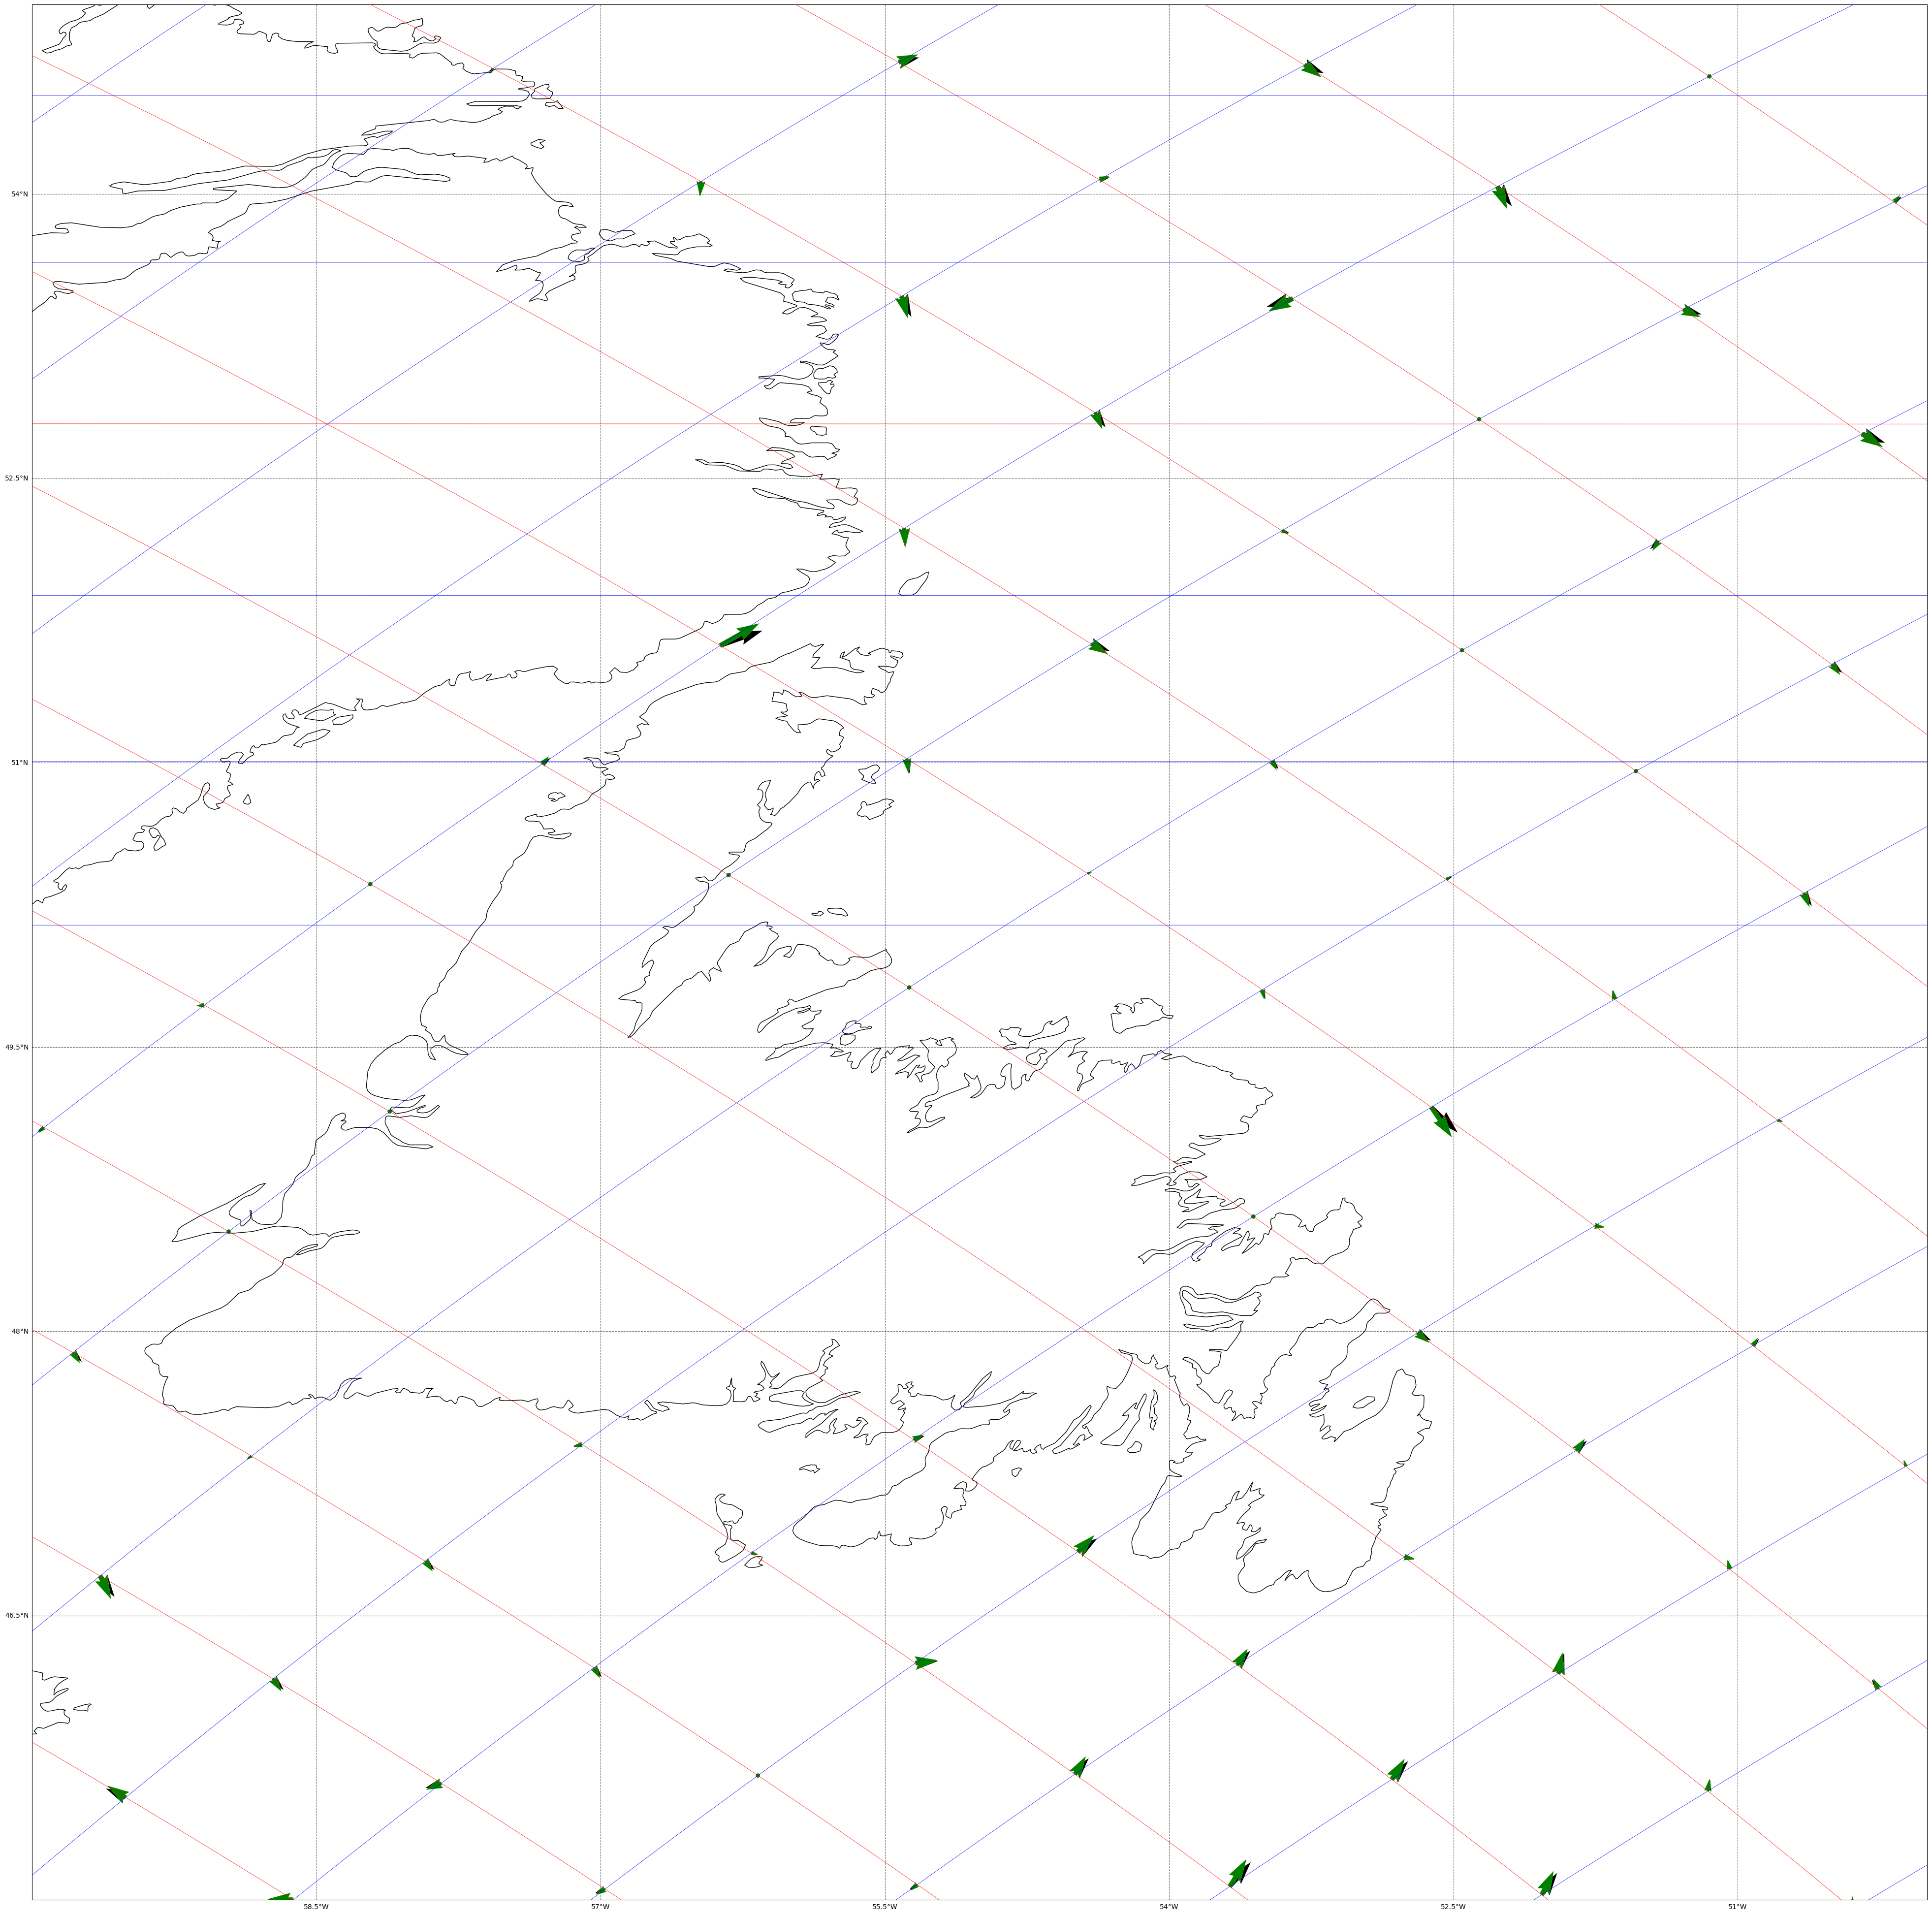

In [100]:
lat = x_vel.latitude.data
lon = x_vel.longitude.data
lon[lon>180] = lon[lon>180]-360
step=20
plt.figure(figsize=(50, 50))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-60, -50, 45, 55], crs=ccrs.PlateCarree())
# ax.set_extent(
#     [
#         x_vel.longitude.data.min(),
#         x_vel.longitude.data.max(),
#         x_vel.latitude.data.min(),
#         x_vel.latitude.data.max(),
#     ],
#     crs=ccrs.PlateCarree(),
# )
gridliner = ax.gridlines(
    draw_labels=True, crs=ccrs.PlateCarree(), color="k", alpha=0.6, linestyle="--"
)
gridliner.top_labels = False
gridliner.right_labels = False

n_y, n_x = lon.shape
for n in range(0, n_y, step):
    plt.plot(lon[n], lat[n], zorder=10, linewidth=0.5, color="red")

for n in range(0, n_x, step):
    plt.plot(lon[:,n], lat[:, n], zorder=10, linewidth=0.5, color="blue")

ax.quiver(
    ps_grid_x[::step,::step],
    ps_grid_y[::step,::step],
    np.deg2rad(x_vel.vozocrtx.data[0,0,::step,::step]),
    np.deg2rad(y_vel.vomecrty.data[0,0,::step,::step]),
    transform=proj,
    color="black"
)

ax.quiver(
    lon[::step,::step],
    lat[::step,::step],
    np.deg2rad(east_vel1[::step,::step]),
    np.deg2rad(north_vel1[::step,::step]),
    transform=ccrs.PlateCarree(),
    color="yellow"
)

ax.quiver(
    lon[::step,::step],
    lat[::step,::step],
    np.deg2rad(east_vel2[::step,::step]),
    np.deg2rad(north_vel2[::step,::step]),
    transform=ccrs.PlateCarree(),
    color="green"
)


plt.show()

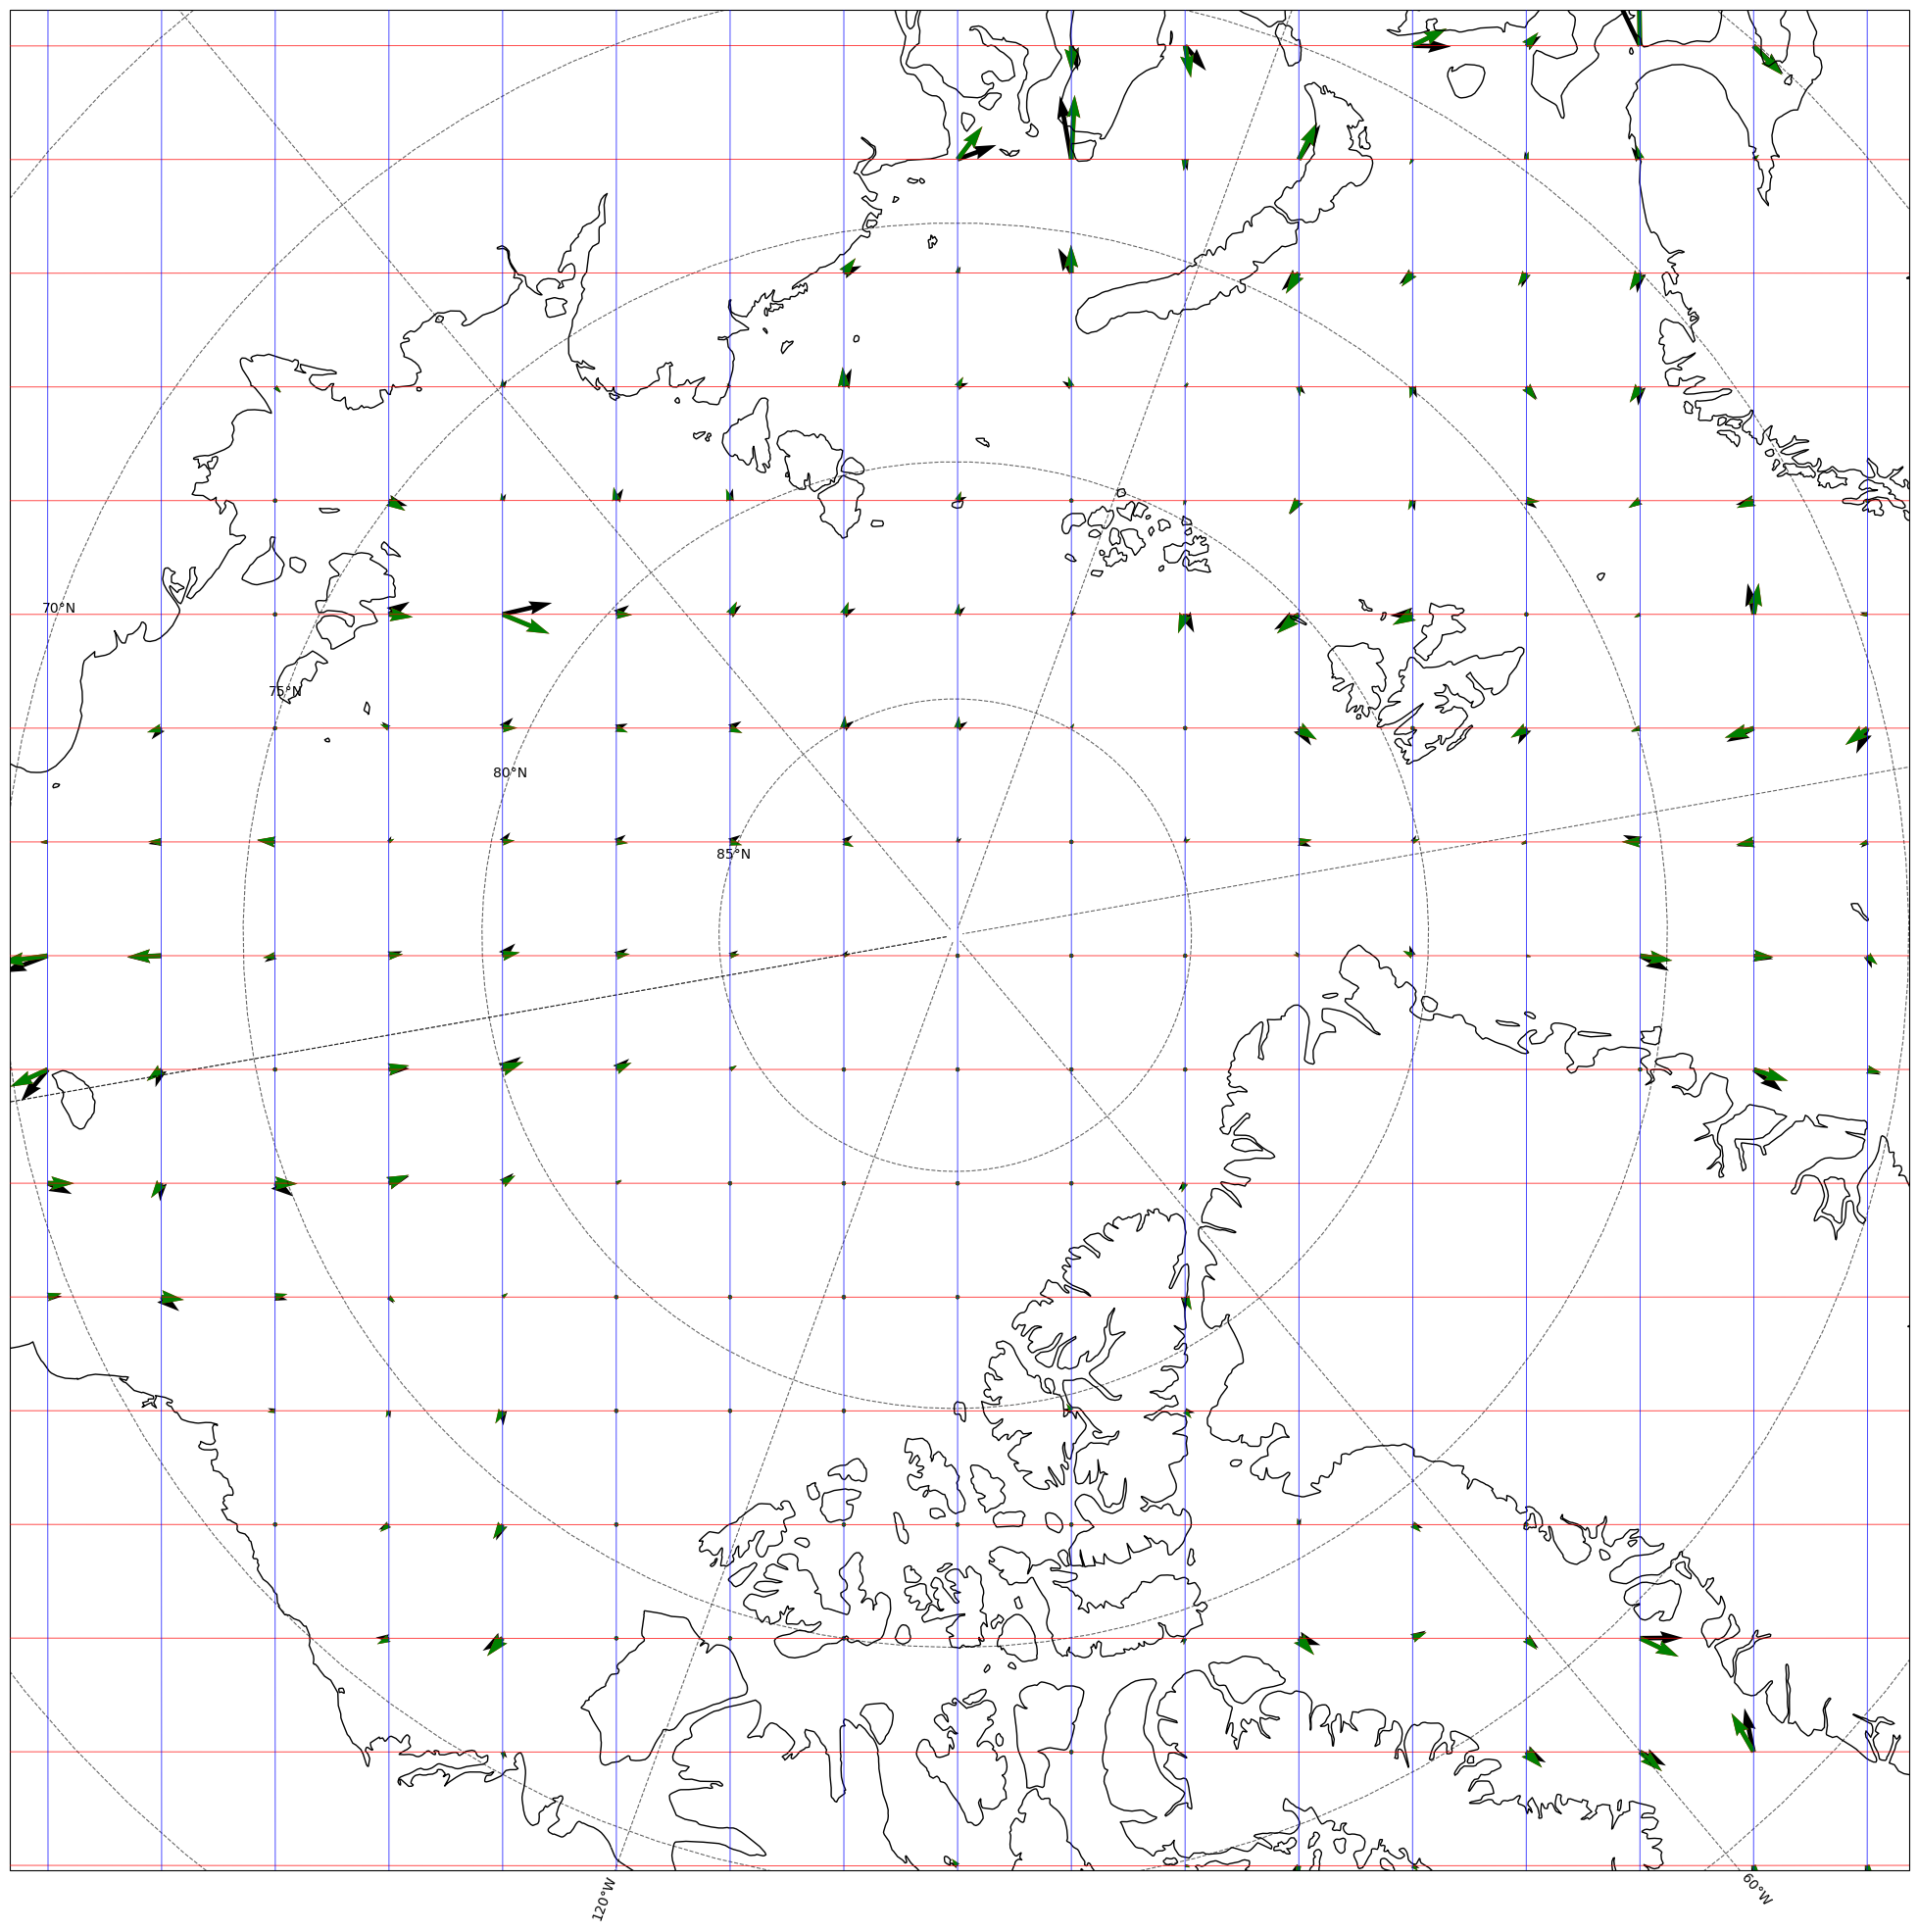

In [101]:
step = 50
plt.figure(figsize=(25, 25))
ax = plt.axes(projection=proj)
ax.coastlines()
# ax.set_extent([-60, -50, 45, 55], crs=ccrs.PlateCarree())
ax.set_extent([-180, 180, 70, 90], crs=ccrs.PlateCarree())
# ax.set_extent(
#     [
#         x_vel.longitude.data.min(),
#         x_vel.longitude.data.max(),
#         x_vel.latitude.data.min(),
#         x_vel.latitude.data.max(),
#     ],
#     crs=ccrs.PlateCarree(),
# )
gridliner = ax.gridlines(
    draw_labels=True, crs=ccrs.PlateCarree(), color="k", alpha=0.6, linestyle="--"
)
gridliner.top_labels = False
gridliner.right_labels = False

n_y, n_x = ps_grid_x.shape
for n in range(0, n_y, step):
    plt.plot(ps_grid_x[n], ps_grid_y[n], zorder=10, linewidth=0.5, color="red")

for n in range(0, n_x, step):
    plt.plot(ps_grid_x[:,n], ps_grid_y[:, n], zorder=10, linewidth=0.5, color="blue")


ax.quiver(
    ps_grid_x[::step,::step],
    ps_grid_y[::step,::step],
    np.deg2rad(x_vel.vozocrtx.data[0,0,::step,::step]),
    np.deg2rad(y_vel.vomecrty.data[0,0,::step,::step]),
    transform=proj,
    color="black"
)

ax.quiver(
    lon[::step,::step],
    lat[::step,::step],
    np.deg2rad(east_vel1[::step,::step]),
    np.deg2rad(north_vel1[::step,::step]),
    transform=ccrs.PlateCarree(),
    color="red"
)

ax.quiver(
    lon[::step,::step],
    lat[::step,::step],
    np.deg2rad(east_vel2[::step,::step]),
    np.deg2rad(north_vel2[::step,::step]),
    transform=ccrs.PlateCarree(),
    color="green"
)  

plt.show()